Neural Networks

implenent neural network classifier

1. CIFAR10 dataset download 
2. Dataset preprocess - numpy import, split
3. Define loss function - cross entropy loss
4. Define L2 regularization
5. Create FC and ReLU forward layer (Manually using NumPy)
6. Create FC and ReLU backward layer (Manually using NumPy)
7. Create three fully connected layer neural network class with training and prediction functions
8. Train and visualize accuracy and loss
9. Hyper parameter tuning and finding the best net.

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import numpy as np
import os
import sys
import urllib.request
import tarfile
import zipfile
from random import randrange
from functools import partial
import itertools

# specify the way plots behave in jupyter notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Data preprocessing


## Data download and processing Helper Code

In [10]:
def maybe_download_and_extract(url, download_dir):
    """
    Download and extract the data if it doesn't already exist.
    Assumes the url is a tar-ball file.
    :param url:
        Internet URL for the tar-file to download.
        Example: "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    :param download_dir:
        Directory where the downloaded file is saved.
        Example: "data/CIFAR-10/"
    :return:
        Nothing.
    """


    filename = url.split('/')[-1]
    file_path = os.path.join(download_dir, filename)

    if not os.path.exists(file_path):
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)

        # Download the file from the internet.
        print("Downloading, This might take several minutes.")
        file_path, _ = urllib.request.urlretrieve(url=url,
                                                  filename=file_path)

        print()
        print("Download finished. Extracting files.")

        if file_path.endswith(".zip"):
            # Unpack the zip-file.
            zipfile.ZipFile(file=file_path, mode="r").extractall(download_dir)
        elif file_path.endswith((".tar.gz", ".tgz")):
            # Unpack the tar-ball.
            tarfile.open(name=file_path, mode="r:gz").extractall(download_dir)

        print("Done.")
    else:
        print("Data has apparently already been downloaded and unpacked.")
        print("If not, delete the dataset folder and try again.")

def load_CIFAR_batch(filename):
    ''' load single batch of cifar '''
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding = 'latin1')
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float")
        Y = np.array(Y)
        return X, Y

def load(ROOT):
    ''' load all of cifar '''
    xs = []
    ys = []
    for b in range(1, 6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

## Data Download

The next cell will download and extract CIFAR-10 into `datasets/cifar10/`. The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images. The dataset is divided into five training batches and one test batch, each with 10,000 images. The test batch contains exactly 1,000 randomly-selected images from each class.


In [11]:
# this cell will download the data if it does not exists
URL = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
PATH = 'datasets/cifar10/' # the script will create required directories
maybe_download_and_extract(URL, PATH) 

Data has apparently already been downloaded and unpacked.
If not, delete the dataset folder and try again.


## Data Preprocessing

In [12]:
CIFAR10_PATH = os.path.join(PATH, 'cifar-10-batches-py')
X_train, y_train, X_test, y_test = load(CIFAR10_PATH) # load the entire data
num_classes = 4

X_train = X_train[np.isin(y_train, range(num_classes))]
y_train = y_train[np.isin(y_train, range(num_classes))]
X_test = X_test[np.isin(y_test, range(num_classes))]
y_test = y_test[np.isin(y_test, range(num_classes))]

# define a splitting for the data
num_training = num_classes*5000
num_validation = 1000
num_testing = 1000

# add a validation dataset for hyperparameter optimization
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]
mask = range(num_validation)
X_val = X_test[mask]
y_val = y_test[mask]
mask = range(num_validation, num_validation+num_testing)
X_test = X_test[mask]
y_test = y_test[mask]

# float64
X_train = X_train.astype(np.float64)
X_val = X_val.astype(np.float64)
X_test = X_test.astype(np.float64)

# subtract the mean from all the images in the batch
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

# flatten all the images in the batch
X_train = np.reshape(X_train, newshape=(X_train.shape[0], -1))
X_val = np.reshape(X_val, newshape=(X_val.shape[0], -1)) 
X_test = np.reshape(X_test, newshape=(X_test.shape[0], -1)) 

print(f"Shape of training set: {X_train.shape}")
print(f"Shape of validation set: {X_val.shape}")
print(f"Shape of test set: {X_test.shape}")

classes = ['plane', 'car', 'bird', 'cat']

Shape of training set: (20000, 3072)
Shape of validation set: (1000, 3072)
Shape of test set: (1000, 3072)


      cat       cat       cat     plane


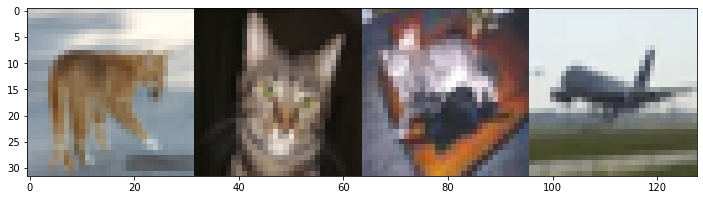

In [13]:
def get_batch(X, y, n=1000):
    rand_items = np.random.randint(0, X.shape[0], size=n)
    images = X[rand_items]
    labels = y[rand_items]
    return images, labels

def make_random_grid(x, y, n=4, convert_to_image=True, random_flag=True):
    if random_flag:
        rand_items = np.random.randint(0, x.shape[0], size=n)
    else:
        rand_items = np.arange(0, x.shape[0])
    images = x[rand_items]
    labels = y[rand_items]
    if convert_to_image:
        grid = np.hstack(np.array([np.asarray((vec_2_img(i) + mean_image), dtype=np.int64) for i in images]))
    else:
        grid = np.hstack(np.array([np.asarray(i, dtype=np.int64) for i in images]))
    print(' '.join('%9s' % classes[labels[j]] for j in range(n)))
    return grid

def vec_2_img(x):
    x = np.reshape(x, (32, 32, 3))
    return x

X_batch, y_batch = get_batch(X_test, y_test, 100)
plt.imshow(make_random_grid(X_batch, y_batch, convert_to_image=True));

# Loss

## Cross-entropy

`softmax_loss` using vectorized code. This function takes as input `scores`, labels `y` and outputs the calculated loss as a single number and the gradients with respect to X.

In [37]:
def softmax_loss(scores, y):
    """
    Computes the loss and gradient for softmax classification.

    Inputs:
    - scores: scores of shape (N, C) where scores[i, c] is the score for class c on input X[i].
    - y: Vector of labels

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """

    N=scores.shape[0]
    ind_vec=np.arange(0, N)
    softmax_matrix=np.exp(scores)/np.sum(np.exp(scores),axis=1)[:,None]
    loss=np.average(-np.log(softmax_matrix[ind_vec, y[ind_vec]]))
    
    dx = np.zeros(scores.shape)
    dx[ind_vec, y[ind_vec]] = 1 #Wt = 1; W{j!=t} = 0;
    dx=np.where(dx, softmax_matrix-1,softmax_matrix)/N #Wt = (Softmax-1)/N; W{j!=t} = (Softmax)/N;
    return loss, dx

In [15]:
# some tests
np.random.seed(42)

num_instances = 5
num_classes = 3

y = np.random.randint(num_classes, size=num_instances)
scores = np.random.randn(num_instances * num_classes).reshape(num_instances, num_classes)
loss, dx = softmax_loss(scores, y)


correct_grad = np.array([[ 0.0062,  0.1751, -0.1813],
         [-0.1463,  0.0561,  0.0901],
         [ 0.0404,  0.0771, -0.1174],
         [ 0.0223,  0.0855, -0.1078],
         [-0.1935,  0.1358,  0.0578]])
correct_loss = 1.7544
assert np.isclose(dx.round(4), correct_grad, rtol=1e-3).all()
assert np.isclose(loss.round(4), correct_loss, rtol=1e-3).all()
print('pass test')

pass test


## L2 Regularization

Regularization (important technique in machine learning to prevent overfitting) adds a regularization term to the loss to penalize larger weights. 
$$
Loss = Loss + \lambda  \cdot \frac{1}{2} \cdot \sum_{i=0}^k w_k^2
$$


In [38]:
def l2_regulariztion_loss(W, reg=0):
    """
    L2 regulariztion loss function, vectorized version.
    - W: a layer's weights.
    - reg: (float) regularization strength
    """
    loss = 0.0
    dW = np.zeros_like(W)
    dW = reg * W
    loss = 0.5 * reg * (np.sum(W ** 2))
    return loss, dW

# Neural Network

building neural network to obtain better results on CIFAR-10. 
train this network using softmax loss and L2 regularization and a ReLU non-linearity.
forward - The forward function will receive inputs, weights and other parameters and will return both an output and a cache object storing data needed for the backward pass.
backward - The backward pass will receive upstream derivatives and the cache, and will return gradients with respect to the inputs and weights.
using `PyTorch`


### Fully Connected Layer: Forward Pass. 

`fc_forward`.

In [17]:
def fc_forward(X, W, b):
    """
    Computes the forward pass for an fully connected layer.
    The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
    examples, where each example x[i] has shape (d_1, ..., d_k). We will
    reshape each input into a vector of dimension D = d_1 * ... * d_k, and
    then transform it to an output vector of dimension M.
    Inputs:
    - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
    - W: A numpy array of weights, of shape (D, M)
    - b: A numpy array of biases, of shape (M,)

    Returns a tuple of:
    - out: output, of shape (N, M)
    - cache: (x, w, b)
    """
    out = None
    D=np.prod(X.shape[1:])
    N=X.shape[0]
    out=np.reshape(X,(N,D)) @ W + b
    cache = (X.copy(), W.copy(), b.copy())
    return out, cache

In [18]:
np.random.seed(42)

num_instances = 5
input_shape = (11, 7, 3)
output_shape = 4

X = np.random.randn(num_instances * np.prod(input_shape)).reshape(num_instances, *input_shape)
W = np.random.randn(np.prod(input_shape) * output_shape).reshape(np.prod(input_shape), output_shape)
b = np.random.randn(output_shape)

out, _ = fc_forward(X, W, b)

correct_out = np.array([[16.77132953,  1.43667172, -15.60205534,   7.15789287],
                        [ -8.5994206,  7.59104298,  10.92160126,  17.19394331],
                        [ 4.77874003,  2.25606192,  -6.10944859,  14.76954561],
                        [21.21222953, 17.82329258,   4.53431782,  -9.88327913],
                        [18.83041801, -2.55273817,  14.08484003,  -3.99196171]])

assert np.isclose(out, correct_out, rtol=1e-8).all()
print('test pass')

test pass


### Fully Connected Layer: Backward Pass 

`fc_backward`

In [19]:
def fc_backward(dout, cache):
    """
    Computes the backward pass for an fully connected layer.
    Try the link in the exercise intructions for more details.

    Inputs:
    - dout: Upstream derivatives
    - cache: Tuple of:
      - X: Input data
      - W: Weights
      - b: Biases

    Returns a tuple of:
    - dx: Gradient with respect to X
    - dw: Gradient with respect to W
    - db: Gradient with respect to b
    """
    x, w, b = cache
    dx, dw, db = 0, 0, 0
    #Dims
    d = x.shape[1:]
    D=np.prod(d)
    N=x.shape[0]

    #dx = upstream_g*w
    dx=np.reshape(dout @ w.T,(N,*d))

    #dw = upstream_g*x
    x_flat=np.reshape(x,(N,D))
    dw=x_flat.T @ dout

    #db = upstream_g*1
    db=dout.T @ np.ones(N)
    return dx, dw, db

In [20]:
def eval_numerical_gradient_array(f, x, df, h=1e-5):
    """
    Evaluate a numeric gradient for a function that accepts a numpy
    array and returns a numpy array.
    """
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index

        oldval = x[ix]
        x[ix] = oldval + h
        pos = f(x).copy()
        x[ix] = oldval - h
        neg = f(x).copy()
        x[ix] = oldval

        grad[ix] = np.sum((pos - neg) * df) / (2 * h)
        it.iternext()
    return grad

In [21]:
np.random.seed(42)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: fc_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: fc_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: fc_forward(x, w, b)[0], b, dout)

out, cache = fc_forward(x,w,b)
dx, dw, db = fc_backward(dout, cache)

assert np.isclose(dw, dw_num, rtol=1e-8).all() # simple test
assert np.isclose(dx, dx_num, rtol=1e-8).all() # simple test
assert np.isclose(db, db_num, rtol=1e-8).all() # simple test
print('test pass')

test pass


### ReLU: Forward Pass 
`relu_forward`

In [22]:
def relu_forward(x):
    """
    Computes the forward pass for a layer of rectified linear units (ReLUs).

    Input:
    - x: Inputs, of any shape

    Returns a tuple of:
    - out: Output, of the same shape as x
    - cache: x
    """
    out = None
    out=np.maximum(x,0)    
    cache = x.copy()
    return out, cache

In [23]:
x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)
out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

assert np.isclose(out, correct_out, rtol=1e-8).all() # simple test
print('pass test')

pass test


### ReLU: Backward Pass

`relu_backward`

In [24]:
def relu_backward(dout, cache):
    """
    Computes the backward pass for a layer of rectified linear units (ReLUs).

    Input:
    - dout: Upstream derivatives, of any shape
    - cache: Input x, of same shape as dout

    Returns:
    - dx: Gradient with respect to x
    """
    dx, x = None, cache
    dx=dout
    dx[cache < 0] = 0
    return dx

In [25]:
np.random.seed(42)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)
dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)
xx, cache = relu_forward(x)
dx = relu_backward(dout, cache)

assert np.isclose(dx, dx_num, rtol=1e-8).all()  # simple test
print('pass test')

pass test


### Combined Layer

In [27]:
def fc_relu_forward(X, W, b):
    """
    Forward pass for a fully connected layer followed by a ReLU.

    Inputs:
    - X: Input to the fc layer
    - W, b: Weights for the fc layer

    Returns:
    - out: Output from the ReLU
    - cache: Object to give to the backward pass
    """
    dout, fc_cache = fc_forward(X,W,b)
    out, relu_cache = relu_forward(dout)
    cache = (fc_cache, relu_cache)
    return out, cache


def fc_relu_backward(dout, cache):
    """
    Backward pass for a fully connected layer followed by a ReLU
    Inputs:
    - dout: upstream derivatives
    - cache: parameters calculated during the forward pass

    Returns:
    - dX: derivative w.r.t X
    - dW: derivative w.r.t W
    - db: derivative w.r.t b
    """
    fc_cache, relu_cache = cache
    out = relu_backward(dout, relu_cache)
    dx, dw, db = fc_backward(out, fc_cache)
    return dx, dw, db

test:

In [28]:
np.random.seed(42)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: fc_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: fc_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: fc_relu_forward(x, w, b)[0], b, dout)

out, cache = fc_relu_forward(x,w,b)
dx, dw, db = fc_relu_backward(dout, cache)

assert np.isclose(dw, dw_num, rtol=1e-8).all() # simple test
assert np.isclose(dx, dx_num, rtol=1e-8).all() # simple test
assert np.isclose(db, db_num, rtol=1e-8).all() # simple test
print('pass test')

pass test


# Building the Network



`ThreeLayerNet`

In [31]:
class ThreeLayerNet(object):
    """
    A three-layer fully-connected neural network. This network has an input dimension of
    N, a hidden layer dimension of H, and performs classification over C classes.
    In our case, we use the same hidden dimension across all hidden layers.
    We train the network with a softmax loss function and L2 regularization on the
    weight matrices. In other words, the network has the following architecture:

    input - fc layer - ReLU - fc layer - ReLu - fc layer - softmax
    The outputs of the third fully-connected layer are the scores for each class.
    """

    def __init__(self, input_size, hidden_size, output_size, std=1e-2):
        """
        Initialize the model. Weights are initialized to small random values and
        biases are initialized to zero. Weights and biases are stored in the
        variable self.params, which is a dictionary with the following keys:

        W1: First layer weights; has shape (D, H)
        b1: First layer biases; has shape (H,)
        W2: Second layer weights; has shape (H, H)
        b2: Second layer biases; has shape (H,)
        W3: Second layer weights; has shape (H, C)
        b3: Second layer biases; has shape (C,)

        Inputs:
        - input_size: The dimension D of the input data.
        - hidden_size: The number of neurons H in each of the hidden layers.
        - output_size: The number of classes C.
        """
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

    def step(self, X, y=None, reg=0.0):
        """
        Compute the loss and gradients for a three layer fully connected neural
        network.

        Inputs:
        - X: Input data of shape (N, D). Each X[i] is a training sample.
        - y: Vector of training labels. This parameter is optional; if it
          is not passed then we only return scores, and if it is passed then we
          instead return the loss and gradients.
        - reg: Regularization coefficient.

        Returns:
        If y is None, return a matrix scores of shape (N, C) where scores[i, c] is
        the score for class c on input X[i].

        If y is not None, instead return a tuple of:
        - loss: Loss (data loss and regularization loss) for this batch of training
          samples.
        - grads: Dictionary mapping parameter names to gradients of those parameters
          with respect to the loss function; has the same keys as self.params.
        """
        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        W3, b3 = self.params['W3'], self.params['b3'] 

        # Compute the forward pass
        scores = None
    
        out1,cache1=fc_relu_forward(X,W1,b1)
        out2,cache2=fc_relu_forward(out1,W2,b2)
        scores, cache3 = fc_forward(out2, W3, b3)

        # If the targets are not given then jump out, we're done
        if y is None:
            return scores

        # Compute the loss
        loss = None
        l2_reg_loss_w1, dW1_reg = l2_regulariztion_loss(W1,reg)
        l2_reg_loss_w2, dW2_reg = l2_regulariztion_loss(W2,reg)
        l2_reg_loss_w3, dW3_reg = l2_regulariztion_loss(W3,reg)
        l2_reg_loss=l2_reg_loss_w1+l2_reg_loss_w2+l2_reg_loss_w3
        loss, dx = softmax_loss(scores,y)
        loss += l2_reg_loss
    
        # Backward pass: compute gradients
        grads = {}
        dx3, dW3, db3 = fc_backward(dx, cache3)
        dx2, dW2, db2 = fc_relu_backward(dx3, cache2)
        dx1, dW1, db1 = fc_relu_backward(dx2, cache1)
        

        grads['b3'] = db3
        grads['b2'] = db2
        grads['b1'] = db1
        
        grads['W1'] = dW1 + dW1_reg
        grads['W2'] = dW2 + dW2_reg
        grads['W3'] = dW3 + dW3_reg
        return loss, grads
    
    def get_batch(X, y, n=1000):
        rand_items = np.random.randint(0, X.shape[0], size=n)
        images = X[rand_items]
        labels = y[rand_items]
        return images, labels
    
    def train(self, X, y, X_val, y_val,
              learning_rate=1e-3, reg=1e-5, num_iters=100,
              batch_size=200, verbose=False):
        """
        Train this neural network using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) giving training data.
        - y: A numpy array f shape (N,) giving training label.
        - X_val: A numpy array of shape (N_val, D) giving validation data.
        - y_val: A numpy array of shape (N_val,) giving validation labels.
        - learning_rate: Scalar giving learning rate for optimization.
        - reg: Scalar giving regularization strength.
        - num_iters: Number of steps to take when optimizing.
        - batch_size: Number of training examples to use per step.
        - verbose: boolean; if true print progress during optimization.
        """
        num_train = X.shape[0]
        iterations_per_epoch = max(num_train / batch_size, 1)

        # Use SGD to optimize the parameters in self.model
        loss_history = []
        train_acc_history = []
        val_acc_history = []

        for it in range(num_iters):
            X_batch = None
            y_batch = None
            X_batch, y_batch = get_batch(X, y, batch_size)

            # Compute loss and gradients using the current minibatch
            loss, grads = self.step(X_batch, y=y_batch, reg=reg)
            loss_history.append(loss)
            W1, b1 = self.params['W1'], self.params['b1']
            W2, b2 = self.params['W2'], self.params['b2']
            W3, b3 = self.params['W3'], self.params['b3'] 
            
            self.params['W1']=self.params['W1']-learning_rate*grads['W1']
            self.params['W2']=self.params['W2']-learning_rate*grads['W2']
            self.params['W3']=self.params['W3']-learning_rate*grads['W3']
            self.params['b1']=self.params['b1']-learning_rate*grads['b1']
            self.params['b2']=self.params['b2']-learning_rate*grads['b2']
            self.params['b3']=self.params['b3']-learning_rate*grads['b3']

            if verbose and (it+1) % 100 == 0:
                print ('iteration %d / %d: loss %f' % (it+1, num_iters, loss))

            # Every epoch, check train and val accuracy.
            if it % iterations_per_epoch == 0:
                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc_history.append(train_acc)
                val_acc_history.append(val_acc)

        return {
          'loss_history': loss_history,
          'train_acc_history': train_acc_history,
          'val_acc_history': val_acc_history,
        }

    def predict(self, X):
        """
        Use the trained weights of this three-layer network to predict labels for
        data points. For each data point we predict scores for each of the C
        classes, and assign each data point to the class with the highest score.

        Inputs:
        - X: data points to classify.

        Returns:
        - y_pred: predicted labels
        """
        y_pred = None
        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        W3, b3 = self.params['W3'], self.params['b3'] 
     
        out1,cache1=fc_relu_forward(X,W1,b1)
        out2,cache2=fc_relu_forward(out1,W2,b2)
        scores, cache3 = fc_forward(out2, W3, b3)
        y_pred = scores.argmax(axis=1)

        return y_pred

In [32]:
input_size = 32 * 32 * 3
hidden_size = 128
num_classes = 4
model = ThreeLayerNet(input_size, hidden_size, num_classes)

In [33]:
stats = model.train(X_train, y_train, X_val, y_val,
            num_iters=1500, batch_size=200,
            learning_rate=1e-3, reg=0, verbose=True)

iteration 100 / 1500: loss 1.084206
iteration 200 / 1500: loss 1.004476
iteration 300 / 1500: loss 0.900380
iteration 400 / 1500: loss 0.825731
iteration 500 / 1500: loss 0.857723
iteration 600 / 1500: loss 0.719607
iteration 700 / 1500: loss 0.754655
iteration 800 / 1500: loss 0.759193
iteration 900 / 1500: loss 0.672972
iteration 1000 / 1500: loss 0.658957
iteration 1100 / 1500: loss 0.763658
iteration 1200 / 1500: loss 0.724688
iteration 1300 / 1500: loss 0.629747
iteration 1400 / 1500: loss 0.711940
iteration 1500 / 1500: loss 0.669238


In [34]:
val_acc = (model.predict(X_val) == y_val).mean()
print ('Validation accuracy: ', val_acc)

Validation accuracy:  0.703


In [35]:
train_acc = (model.predict(X_train) == y_train).mean()
print ('Training accuracy: ', train_acc)

Training accuracy:  0.7445


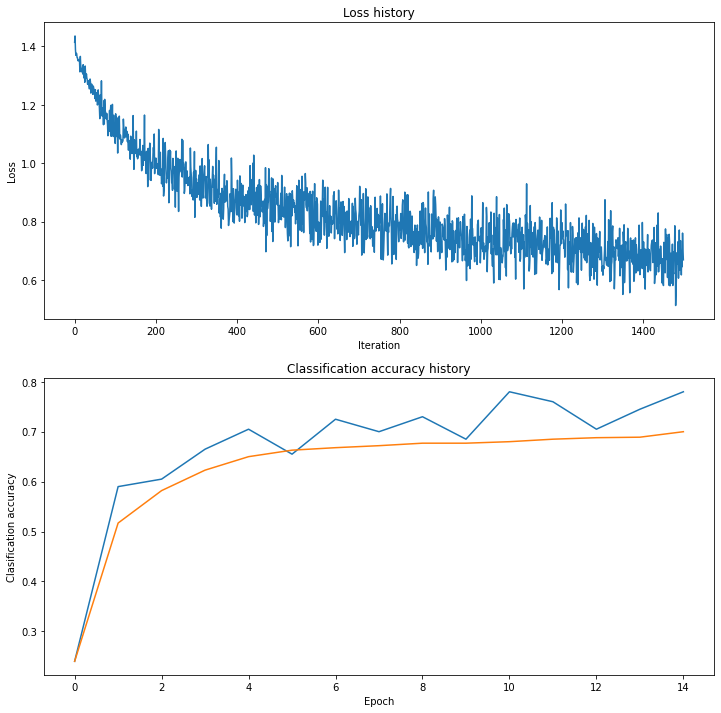

In [36]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

## Hyperparameter Optimization
Using the validation set to tune hyperparameters by training different models (using the training dataset) and evaluating the performance using the validation dataset. Saving the results in a dictionary mapping tuples of the form `(learning_rate, hidden_size, regularization)` to tuples of the form `(training_accuracy, validation_accuracy)`. 

In [175]:
learning_rates = [1e-4, 1e-3]
hidden_sizes = [32, 64, 128, 256]
regularizations = [0, 0.001, 0.1, 0.25] 

results = {}
best_val = -1   
best_net = None 

"""
input_size = 32 * 32 * 3
hidden_size = 128
num_classes = 4

"""
for lr in learning_rates:
    for hidden_size in hidden_sizes:
        for reg in regularizations:
            print('training neural network regression learning rate {} hidden size {} regularization {}'.format(lr,hidden_size, reg))
            current_model = ThreeLayerNet(input_size, hidden_size, num_classes)
            stats = current_model.train(X_train, y_train, X_val, y_val,
                num_iters=1500, batch_size=200,
                learning_rate=lr, reg=reg, verbose=False)
            validation_accuracy = (current_model.predict(X_val) == y_val).mean()
            training_accuracy = (current_model.predict(X_train) == y_train).mean()
            results[(lr, hidden_size, reg)] = (training_accuracy,validation_accuracy)
            if validation_accuracy > best_val:
                best_net=current_model
                best_val=validation_accuracy


# Print out results.
for lr, hidden_size, reg  in sorted(results):
    train_accuracy, val_accuracy = results[(lr, hidden_size, reg)]
    print ('lr %e hidden_size %f reg %f train accuracy: %f val accuracy: %f' % (
                lr, hidden_size, reg, train_accuracy, val_accuracy))
    
print ('best validation accuracy achieved during cross-validation: %f' % best_val)

test_accuracy = (model.predict(X_test) == y_test).mean()
print ('Neural Network on raw pixels final test set accuracy: %f' % test_accuracy)

training neural network regression learning rate 0.0001 hidden size 32 regularization 0
training neural network regression learning rate 0.0001 hidden size 32 regularization 0.001
training neural network regression learning rate 0.0001 hidden size 32 regularization 0.1
training neural network regression learning rate 0.0001 hidden size 32 regularization 0.25
training neural network regression learning rate 0.0001 hidden size 64 regularization 0
training neural network regression learning rate 0.0001 hidden size 64 regularization 0.001
training neural network regression learning rate 0.0001 hidden size 64 regularization 0.1
training neural network regression learning rate 0.0001 hidden size 64 regularization 0.25
training neural network regression learning rate 0.0001 hidden size 128 regularization 0
training neural network regression learning rate 0.0001 hidden size 128 regularization 0.001
training neural network regression learning rate 0.0001 hidden size 128 regularization 0.1
train

# The End